# import packages

In [1]:
import os # import OS package
import numpy as np # import numpy package
import pandas as pd # import package
import matplotlib.pyplot as pl # import matplotlib.pyplot

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor as NN
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import pylab as pl
from mpl_toolkits.mplot3d import Axes3D

print("Done :)")

Done :)


# setup working directory

In [2]:
current_dir = os.getcwd( )
my_dir = 'c:\\Users\\PAUL\\Documents\\A_Maynooth HDip\\NCG603A (NCG613) - Geocomputation\\Python project'
if current_dir != my_dir:
        print("Setting up working directory...")
        os.chdir(my_dir)        
print("Current working directory is: ", os.getcwd( ))


Setting up working directory...
Current working directory is:  c:\Users\PAUL\Documents\A_Maynooth HDip\NCG603A (NCG613) - Geocomputation\Python project


# import dataset

In [3]:
hp = pd.read_csv('hpdemo.csv',dtype=float) # import dataset

print(hp.head(5)) # quick look at dataset portion (first 10 rows)

    ID      east     north     price  fl_area
0  1.0  523800.0  179700.0  107000.0     50.0
1  2.0  533200.0  170900.0   55500.0     66.0
2  3.0  514600.0  175800.0  103000.0     90.0
3  4.0  516000.0  171000.0  187000.0    125.0
4  5.0  533700.0  169200.0   43000.0     50.0


# Develop an ML model for predictions: opt_nn

In [4]:
# instantiate a (standard) scaler object for scaling the input data
x_scaler = StandardScaler()

 # calibrate the scaler object
x_scaler.fit(hp[['east','north','fl_area']])

# transform data to standardized z-scores, store in X
X = x_scaler.transform(hp[['east','north','fl_area']]) # 'X' now contains z-scored, rescaled data

# the 'make_scorer' function creates a scoring object and 'mean_absolute_error' specifies the type of scorer to use
mae = make_scorer(mean_absolute_error, greater_is_better = False)

# divided prices by 1,000 to help avoid rounding errors later
price = hp['price']/1000.0

## Use GridSearchCV to perform cross-validation on ML model: opt_nn

In [5]:
# Use 'GridSearchCV' to carry out the cross-validation process on the ML model chosen
# (i.e. estimator is NN, scoring is mae, tuning params as specified in param_grid for estimator=NN) 
opt_nn = GridSearchCV( 
                       estimator = NN(),
                       scoring = mae,
                       # param_grid holds the tuning parameters for NN (n_neighbors, weights, p)
                       param_grid = { 'n_neighbors':range(1,35), 'weights':['uniform', 'distance'], 'p':[1,2] }
                     )

# calibrate the model
opt_nn.fit(X, price)

# use the model (i.e. opt_nn) to perform the prediction - input unscaled data to scaler object's transform method
predicted_hp = opt_nn.predict(x_scaler.transform([[523800.0,179750.0,55.0]]));
print(predicted_hp)

C:\Users\PAUL\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[121.78783506]


## Extract information about the model: opt_nn

In [6]:
# use a function to extract GridSearchCV (cross validation) results - best set of params to use i.e. yields best MAE score
def print_summary(opt_reg_object):
    params = opt_reg_object.best_estimator_.get_params()
    score = - opt_reg_object.best_score_
    print("Nearest neighbours: %8d" % params['n_neighbors'])
    print("Minkowski p       : %8d" % params['p'])
    print("Weighting         : %8s" % params['weights'])
    print("MAE Score         : %8.2f" % score)
    return


In [7]:
# call function
print_summary(opt_nn)


Nearest neighbours:       13
Minkowski p       :        1
Weighting         : distance
MAE Score         :    26.49


# Pipelines - automate ML model design & cross validation process: opt_nn2

In [8]:
# use pipelines with 'GridSearchGV'
pipe = Pipeline( [ ('zscores', StandardScaler()), ('NNreg',NN())] )

# pipe now becomes the estimator
opt_nn2 = GridSearchCV(
                        estimator = pipe,
                        scoring = mae,
                        param_grid = {
                        'NNreg__n_neighbors':range(1,35),
                        'NNreg__weights':['uniform','distance'],
                        'NNreg__p':[1,2]}
                      )

# calibrate the new model as before
opt_nn2.fit(hp[['east','north','fl_area']], price)

# repeat the prediction step - input unscaled data to 'pipe' predict method
# the pipe object is defined with StandardScaler
predicted_hp2 = opt_nn2.predict([[523800.0,179750.0,55.0]])

C:\Users\PAUL\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


## Extract information about the model: opt_nn2

In [9]:
# use the best_estimator_ and best_score_ techniques to find the tuning parameters and score
def print_summary2(opt_pipe_object):
    params = opt_pipe_object.best_estimator_.get_params()
    score = - opt_pipe_object.best_score_
    print("Nearest neighbours: %8d" % params['NNreg__n_neighbors'])
    print("Minkowski p       : %8d" % params['NNreg__p'])
    print("Weighting         : %8s" % params['NNreg__weights'])
    print("MAE Score         : %8.2f" % score)
    return

# call function
print_summary2(opt_nn2)


Nearest neighbours:       13
Minkowski p       :        1
Weighting         : distance
MAE Score         :    26.47


# Visualising

In [10]:
# To cover the area in the data, eastings should range from 505000 to 555800, and northings from 158400 to 199900.
# Create a grid of 100 by 100 points
east_mesh, north_mesh = np.meshgrid(np.linspace(505000,555800,100), np.linspace(158400,199900,100))

# verify prediction variables are all available in the form of 2D arrays
print('easting grid', east_mesh.shape)
print('northing grid', north_mesh.shape)

# creates a new array of the same shape as 'east_mesh' and north_mesh but containing only zeros
fl_mesh = np.zeros_like(east_mesh)

# assign every element of this new array with the average floor size
fl_mesh[:,:] = np.mean(hp['fl_area'])
print('floor area grid', fl_mesh.shape)


easting grid (100, 100)
northing grid (100, 100)
floor area grid (100, 100)


## Define function to create 3d plot - takes ML input model to use and floor area (sqm)

In [22]:
def draw_surf3d(ML_inputModel,fl_area):
    
    # define easting, northing limits and grid size
    east_mesh, north_mesh = np.meshgrid(np.linspace(505000,555800,100), np.linspace(158400,199900,100))
    
    # creates a new array of the same shape as 'east_mesh' but containing only zeros
    fl_mesh = np.zeros_like(east_mesh)
    
    # assign every element of this array with fl_area
    fl_mesh[:,:] = fl_area
    
    grid_predictor_vars = np.array([east_mesh.ravel(), north_mesh.ravel(),fl_mesh.ravel()]).T
    hp_pred = ML_inputModel.predict(grid_predictor_vars)
    
    hp_mesh = hp_pred.reshape(east_mesh.shape)
    
    # build plot, colour surface, annotate axes
    fig = pl.figure()
    ax = Axes3D(fig)
    ax.plot_surface(east_mesh, north_mesh, hp_mesh, rstride=1, cstride=1, cmap='YlOrBr',lw=0.01)
    
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    
    zlabel_extra = 'Price at ' + str(fl_area) + 'sqm floor area'
    ax.set_zlabel(zlabel_extra)
    # pl.show() # disabled so that result can be assigned
    
    return


# Create figures with alternative floor area values:
## mean floor area, 75sqm & 125sqm

From below there appears to be no significant differences between the three measures apart from the secondary peaks in prices. The mean floor area prices exhibit a slightly tighter grouped range of prices around peak value. The 75sqm floor area prices seem to have a slightly more spread out range of values around it's peak. It also seems to have a secondary peak at around (easting:515000) and (northing:180000). The 125sqm floor area prices plot is spread out even further from it's peak. Again it has a secondary peak which in this case appears almost like a plateau running between (easting:510000 & 520000) and (northing:180000 & 190000).

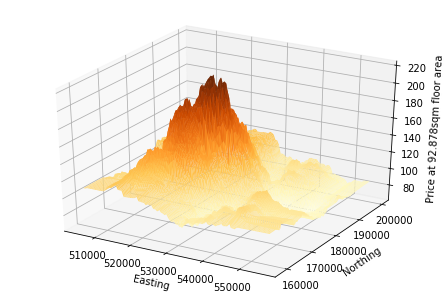

In [23]:
# mean sqm
pl.close()
draw_surf3d(opt_nn2, round(np.mean(hp['fl_area']),3) ) # rounded the mean value to 2 decimal places
pl.show()

Mean floor area prices: This has main peak at around (easting:515000) and (northing:190000). Smaller peak at similar easting but northing closer to 180000 - Southhall, West London.

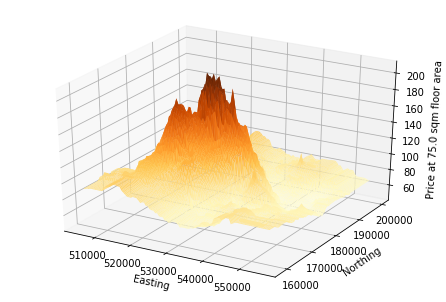

In [13]:
# 75sqm
pl.close()
draw_surf3d(opt_nn2,75.0)
pl.show()

75sqm floor area prices: This has similar peak as above at (easting:515000) and (northing:190000) - Harrow Weld, NW London

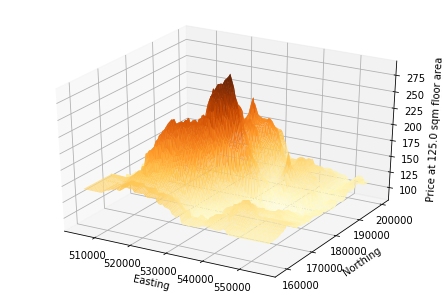

In [14]:
# 125sqm
pl.close()
draw_surf3d(opt_nn2,125.0)
pl.show()

125sqm floor area prices: This plot exhibits one main peak and two secondary peaks. The first plateaus between (easting:510000 & 520000) and (northing:180000 & 190000) - Hayes, West London; the second 'spikes' at around (easting: 525000) and (northing:200000) - Potter's Bar area, North London.